In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
warnings.filterwarnings('ignore')

In [55]:
train_data = pd.read_csv('train.csv')

train_data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4884,10998,6,2.0,52.703116,4.682974,1.0,17,17.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B,153296.980210
179,11413,86,1.0,36.805826,17.986014,7.0,10,12.0,1974,0.161976,B,A,31,7010,5,4508.0,3,7,B,183891.147301
8409,6514,94,1.0,45.902534,17.229169,10.0,27,25.0,2016,0.282798,B,B,33,8667,2,NaN,0,6,B,91816.819026
3152,233,18,1.0,40.489842,23.174794,7.0,5,15.0,2001,0.000000,B,B,30,5562,0,NaN,0,5,A,195089.174745
8213,6536,15,1.0,41.245823,21.295424,7.0,5,16.0,2009,0.158249,B,B,21,5731,0,NaN,1,0,B,148884.403770
8701,9815,12,3.0,85.780610,51.107723,8.0,2,12.0,1996,0.090799,B,B,74,19083,2,NaN,5,15,B,291231.806250
3111,2543,59,1.0,40.354646,24.012685,6.0,2,14.0,1974,0.309479,B,B,35,7715,4,990.0,0,6,B,156736.450108
3163,4083,58,2.0,66.357288,65.874526,0.0,3,12.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,152850.133640
4224,8297,155,3.0,66.258469,45.437252,6.0,3,12.0,1977,0.042307,B,B,17,2810,9,4849.0,3,6,B,310139.659847
928,14575,67,2.0,46.350558,31.191642,6.0,6,9.0,1974,0.100456,B,B,43,7227,0,NaN,1,6,A,214473.371739


### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [58]:
class DataPipeline:    
    def __init__(self, **kwargs):
        """Параметры класса"""
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def fit(self, df):
        """Обучение модели"""
        
    def transform(self, column):
        """Трансформация данных"""
        
        # вычисляем z-Score для цены
        z = np.abs(stats.zscore(self.data[column]))
        # пороговое значение z-score в три сигмы
        threashold = 3
        # среднее ппоскольку цена имеет близкое к нормальному распределение
        self.data.loc[z > threashold, column] = self.data[column].mean()
        
        #train_data[column] = winsorize(self.data[column], limits=[0.1, 0.1])

    def plot(self, column):
        plt.figure(figsize = (16, 8))
        
        sns.distplot(self.data[column], bins=50)
        
        target_mean = round(self.data[column].mean(), 2)
        target_median = self.data[column].median()
        target_mode = self.data[column].mode()[0]
        
        y = np.linspace(0, 0.000005, 10)
        plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
        plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
        plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)
        
        plt.title(f'Distribution of {column}')
        plt.legend()
        plt.show()        

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [59]:
pipeline = DataPipeline(data=train_data)

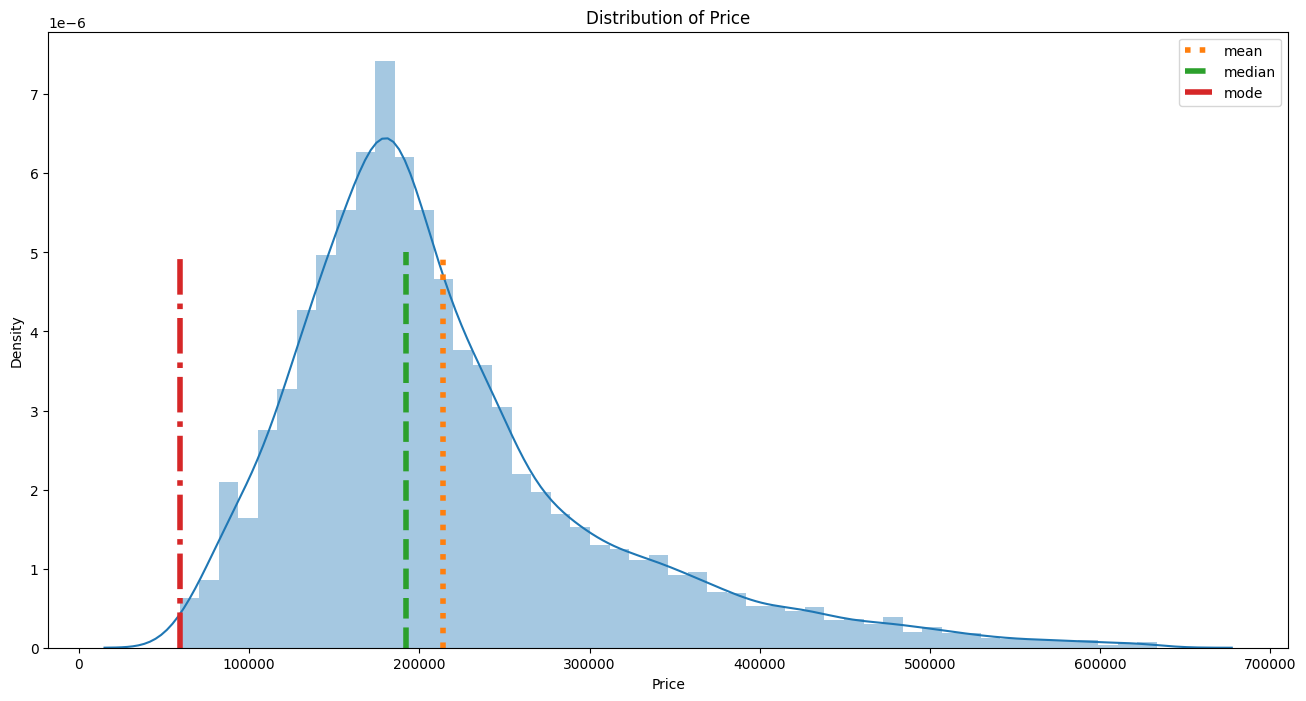

In [60]:
pipeline.plot('Price')

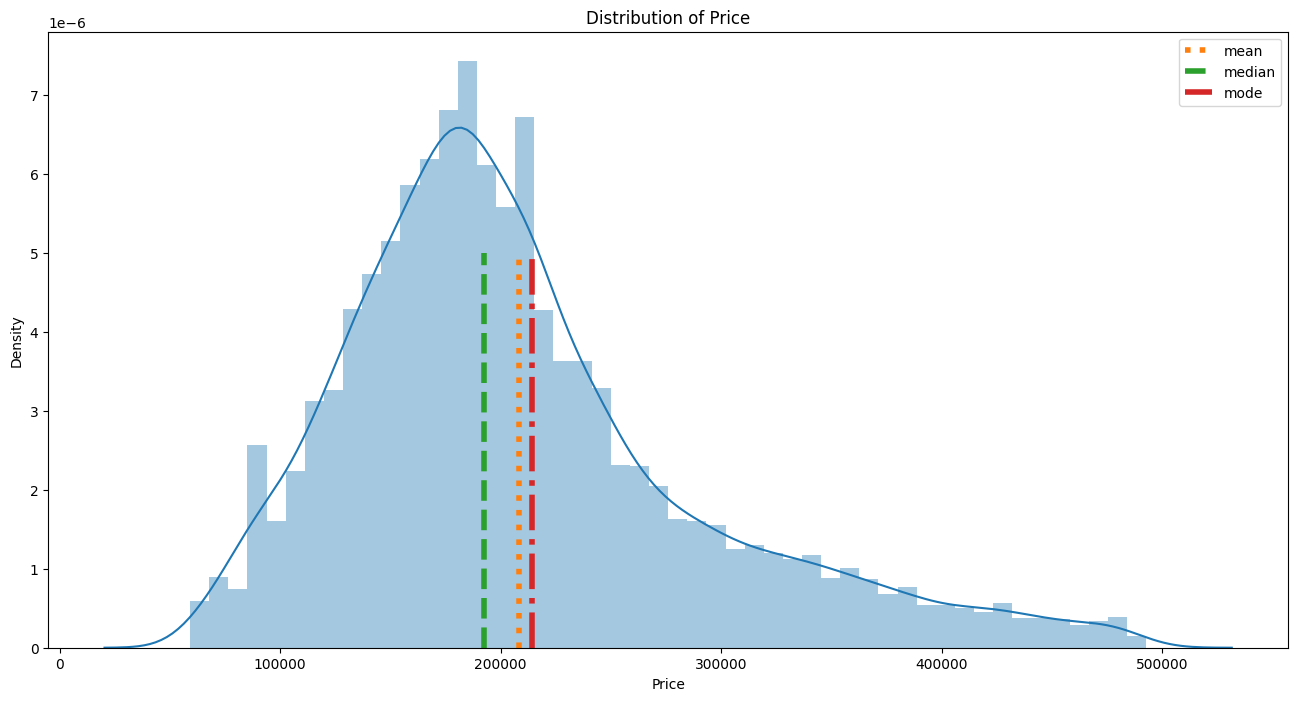

In [62]:
pipeline.transform('Price')
pipeline.plot('Price')

In [41]:
train_data.isna().sum()[train_data.isna().sum() > 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [40]:
train_data.DistrictId = train_data.DistrictId.astype("category")

In [42]:
df_num_features = train_data.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644
